This code calculates the files that are loaded to create Figure 2 in the paper. Since it is a very computer intensive calculation, the number of paths are lower than what was used to create the files. Also, the original files used GPUs on Google Colab. 

In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import gc
import requests
import pandas as pd
import io  # Import the io module

/Users/christianheyerdahl-larsen/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getExpectedShortRate(f, l, tau, pars, M, dt, device):
    rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars

    NT = round(tau / dt)  # Number of time steps

    # Initialize tensors for all paths under each of the three beliefs
    ft = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)
    fat = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)
    fbt = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)

    lt = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)
    lat = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)
    lbt = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)

    # Generate random numbers for all paths and time steps. Make sure to check the change of measure here!
    dZ = torch.sqrt(torch.tensor(dt, dtype=torch.float32, device=device)) * torch.randn(NT, M, device=device)
    dZa = dZ - torch.ones(NT, M, device=device) * torch.tensor(0.5 * DEL * dt, dtype=torch.float32, device=device)
    dZb = dZ + torch.ones(NT, M, device=device) * torch.tensor(0.5 * DEL * dt, dtype=torch.float32, device=device)

    rbar = muY - sigY**2  # This should probably be moved outside the loop as a constant

    for i in range(NT):
        # Under objective
        alpt = 1 / (1 + torch.exp(-lt))
        phit = ft / (rhoA + nu) + (1 - ft) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        muft = nu * (alpt * betAt * (1 - ft) - (1 - alpt) * betBt * ft) + (rhoB - rhoA) * ft * (1 - ft) + DEL**2 * (1/2 - ft) * ft * (1 - ft)
        sigft = ft * (1 - ft) * DEL
        dft = muft * dt + sigft * dZ[i, :]
        dlt = kap * (lbar - lt) * dt + sig_l * dZ[i, :]

        lt = lt + dlt  # update lt
        ft = ft + dft  # update ft
        r = rbar + rhoA * ft + rhoB * (1 - ft) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        # Under agent a
        alpt = 1 / (1 + torch.exp(-lat))
        phit = fat / (rhoA + nu) + (1 - fat) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        mufat = nu * (alpt * betAt * (1 - fat) - (1 - alpt) * betBt * fat) + (rhoB - rhoA) * fat * (1 - fat) + DEL**2 * (1/2 - fat) * fat * (1 - fat)
        sigfat = fat * (1 - fat) * DEL
        dfat = mufat * dt + sigfat * dZa[i, :]
        dlat = kap * (lbar - lat) * dt + sig_l * dZa[i, :]

        lat = lat + dlat  # update lat
        fat = fat + dfat  # update fat
        ra = rbar + rhoA * fat + rhoB * (1 - fat) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        # Under agent b
        alpt = 1 / (1 + torch.exp(-lbt))
        phit = fbt / (rhoA + nu) + (1 - fbt) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        mufbt = nu * (alpt * betAt * (1 - fbt) - (1 - alpt) * betBt * fbt) + (rhoB - rhoA) * fbt * (1 - fbt) + DEL**2 * (1/2 - fbt) * fbt * (1 - fbt)
        sigfbt = fbt * (1 - fbt) * DEL
        dfbt = mufbt * dt + sigfbt * dZb[i, :]
        dlbt = kap * (lbar - lbt) * dt + sig_l * dZb[i, :]

        lbt = lbt + dlbt  # update lbt
        fbt = fbt + dfbt  # update fbt
        rb = rbar + rhoA * fbt + rhoB * (1 - fbt) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        DIS = 0.5 * np.abs(torch.mean(rb).item() - torch.mean(ra).item())

    return torch.mean(r).item(), torch.mean(ra).item(), torch.mean(rb).item(), DIS


In [3]:
def simulateTSofDisagreement(f, l, T, tau_values, pars, M, dt, device):
    rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars

    NT = round(T / dt)  # Number of time steps

    # Initialize variables
    ft = f
    lt = l
    dZ = np.sqrt(dt) * np.random.randn(NT, len(tau_values))
    DIS_values = np.zeros((NT, len(tau_values)))
    rbar = muY - sigY**2  # Moved outside the loop

    for i in range(NT):
        for j in range(len(tau_values)):
            r, ra, rb, current_DIS = getExpectedShortRate(ft, lt, tau_values[j], pars, M, dt, device)
            DIS_values[i, j] = current_DIS

        # Update ft and lt
        alpt = 1 / (1 + np.exp(-lt))
        phit = ft / (rhoA + nu) + (1 - ft) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        muft = nu * (alpt * betAt * (1 - ft) - (1 - alpt) * betBt * ft) + (rhoB - rhoA) * ft * (1 - ft) + DEL**2 * (1/2 - ft) * ft * (1 - ft)
        sigft = ft * (1 - ft) * DEL
        dft = muft * dt + sigft * dZ[i, j]
        dlt = kap * (lbar - lt) * dt + sig_l * dZ[i, j]

        lt = lt + dlt  # update lt
        ft = ft + dft  # update ft

    return DIS_values

In [4]:
def getShortRate(f, alp, tau, pars):
  rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars
  phiA = 1/(rhoA + nu)
  phiB = 1/(rhoB + nu)
  phi = f*phiA + (1-f)*phiB
  betA = (rhoA+nu)*phi
  betB = (rhoB+nu)*phi
  bet = alp*betA+(1-alp)*betB
  rhot = f*rhoA+(1-f)*rhoB
  r = rhot + muY-sigY**2 + nu*(1-bet)
  return r

We need to invert the disagreement. Hence, we define a function based on a simple method.

In [5]:
def find_closest_f(target_DIS,target_r, alp, tau, pars, M, dt, device, num_points=20):
    """
    Find the value of f in the interval [0, 1] for which the DIS output of
    getExpectedShortRate is closest to the target DIS value.

    :param target_DIS: The target DIS value to match.
    :param alp, tau, pars, M, dt, device: Parameters to be passed to getExpectedShortRate.
    :param num_points: Number of points to sample in the interval [0, 1].
    :return: The value of f closest to the target DIS.
    """

    # Generate a range of f values to test
    f_values = np.linspace(0, 1, num_points)

    # Initialize variables to store the best results
    closest_f = None
    closest_DIS_diff = float('inf')

    # Loop over all possible f values
    for f in f_values:
        _, _, _, DIS = getExpectedShortRate(f, alp, tau, pars, M, dt, device)
        r = getShortRate(f, alp, tau, pars)
        # Calculate the difference from the target DIS
        DIS_diff = abs(DIS - target_DIS)+0.2*abs(target_r-r)

        # Update the closest values if this is the best so far
        if DIS_diff < closest_DIS_diff:
            closest_f = f
            closest_DIS_diff = DIS_diff

    return closest_f

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Device:", device)

Device: cpu


In [7]:
DEL = 0.8 
rhoA = -0.015
rhoB = 0.025
nu = 0.02
kap = 0.01
lbar = 0
sig_l = 0.1
muY = 0.02
sigY = 0.033
pars = [rhoA , rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY]

In [8]:
dt = 1 / 12
M = 1000  # Number of paths.  Originally set to 50000

In [9]:
#A little test
f = 0.5
alp = 0.5
tau = 1
l = -np.log(1/alp-1)
r, ra, rb, DIS = getExpectedShortRate(f, l, tau, pars, M, dt, device)
print(f"expected interest rate true: {r}")
print(f"expected interest rate agent a: {ra}")
print(f"expected interest rate agent b: {rb}")
print(f"expected interest rate agent b: {DIS}")


expected interest rate true: -0.010117655619978905
expected interest rate agent a: -0.0025341687723994255
expected interest rate agent b: -0.01753207854926586
expected interest rate agent b: 0.007498954888433218


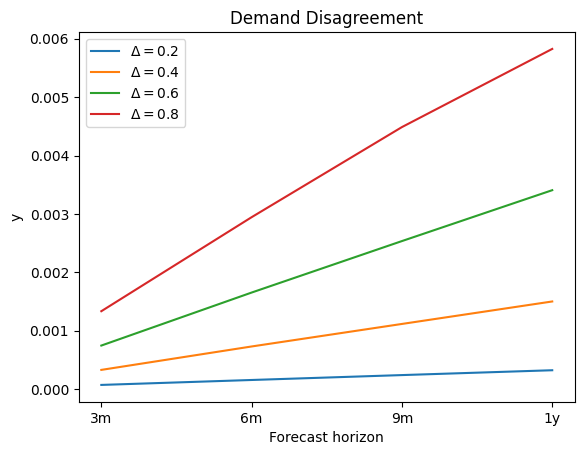

In [10]:
# Define the tau values in months
tau_values = np.array([3/12, 6/12, 9/12, 1])  # Corresponding to 3m, 6m, 9m, 1 year
months = ['3m', '6m', '9m', '1y']  # Labels for the x-axis

parsNew = pars
r_values = []
ra_values = []
rb_values = []
DIS02_values = []
DIS04_values = []
DIS06_values = []
DIS08_values = []

alp = 0.5
f02 = 0.333
f04 = 0.317
f06 = 0.297
f08 = 0.290

for tau in tau_values:
    # For DEL=0.2
    parsNew[3] = 0.2
    r, ra, rb, DIS = getExpectedShortRate(f02, alp, tau, parsNew, M, dt, device)
    r_values.append(r)
    ra_values.append(ra)
    rb_values.append(rb)
    DIS = np.abs(ra - rb) / 2
    DIS02_values.append(DIS)

    # For DEL=0.4
    parsNew[3] = 0.4
    r, ra, rb, DIS = getExpectedShortRate(f04, alp, tau, parsNew, M, dt, device)
    r_values.append(r)
    ra_values.append(ra)
    rb_values.append(rb)
    DIS = np.abs(ra - rb) / 2
    DIS04_values.append(DIS)

    # For DEL=0.6
    parsNew[3] = 0.6
    r, ra, rb, DIS = getExpectedShortRate(f06, alp, tau, parsNew, M, dt, device)
    r_values.append(r)
    ra_values.append(ra)
    rb_values.append(rb)
    DIS = np.abs(ra - rb) / 2
    DIS06_values.append(DIS)

    # For DEL=0.8
    parsNew[3] = 0.8
    r, ra, rb, DIS = getExpectedShortRate(f08, alp, tau, parsNew, M, dt, device)
    r_values.append(r)
    ra_values.append(ra)
    rb_values.append(rb)
    DIS = np.abs(ra - rb) / 2
    DIS08_values.append(DIS)

# Plotting the results
plt.plot(months, DIS02_values, label=f'$\Delta = 0.2$')
plt.plot(months, DIS04_values, label=f'$\Delta = 0.4$')
plt.plot(months, DIS06_values, label=f'$\Delta = 0.6$')
plt.plot(months, DIS08_values, label=f'$\Delta = 0.8$')

plt.xlabel('Forecast horizon')
plt.ylabel('y')
plt.title('Demand Disagreement')
plt.legend()
plt.show()


In [11]:
tau_values = np.array([3/12, 6/12, 9/12, 1])
parsNew = pars
T = 100 #Original was T=1000 
f02 = 0.333
f04 = 0.317
f06 = 0.297
f08 = 0.290
alp = 0.5
l = -np.log(1/alp-1)
parsNew[3] = 0.2
DIS02 = simulateTSofDisagreement(f02, l, T, tau_values, parsNew, M, dt, device)
parsNew[3] = 0.4
DIS04 = simulateTSofDisagreement(f04, l, T, tau_values, parsNew, M, dt, device)
parsNew[3] = 0.6
DIS06 = simulateTSofDisagreement(f06, l, T, tau_values, parsNew, M, dt, device)
parsNew[3] = 0.8
DIS08 = simulateTSofDisagreement(f08, l, T, tau_values, parsNew, M, dt, device)

In [12]:
# Save the arrays to .npy files
np.save('Data/Model Disagreement/DIS02V2_SHORTTEST.npy', DIS02)
np.save('Data/Model Disagreement/DIS04V2_SHORTTEST.npy', DIS04)
np.save('Data/Model Disagreement/DIS06V2_SHORTTEST.npy', DIS06)
np.save('Data/Model Disagreement/DIS08V2_SHORTTEST.npy', DIS08)